In [1]:
#Import packages
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(vegan)
library(microbiome)
library(phyloseq)
library(pairwiseAdonis)
library(PCAtools)
library("tidyverse")
library("dplyr")

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:vegan’:

    diversity


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


Loading required package: cluster

Loading required package: ggrepel


Attaching package: ‘PCAtools’


The following objects are masked from ‘package:stats’:

    biplot, screeplot


── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.1.2     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1
✔ dplyr   1.0.8     

── Conflic

In [2]:
# Read in the 16S qza files and clean them up for phyloseq
ASVtable_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/tableV_BacArc_99_SCTLD.qza")
ASVtable_16S <- ASVtable_16S$data # Extract the count data from list
ASVtaxa_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/taxaVsearch_rep-seqs-dn-99_SCTLD.qza")
taxtable_16S <- ASVtaxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) 
# Convert taxonomy info to data frame with correct taxonomy labels
taxtable_16S <- taxtable_16S[-1,]
#asv_tab$asv_id <- rownames(asv_tab) # add a new column for ids




Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 70468 rows [2, 7, 11, 13, 15, 17, 21, 23, 27, 29, 34, 38, 39, 41, 43, 46, 47, 50, 54, 56, ...].”


In [3]:
sample_info_tab_16S <- read.csv("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/metadata_for_qiime/SCTLD_meta_analysis_metadata.csv",
                                header = T, row.names = 1,
na.strings = c("", "NA")) 

In [4]:
physeq_16S <- phyloseq(otu_table(ASVtable_16S, taxa_are_rows= T),
tax_table(as.data.frame(taxtable_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
physeq_16S
#taxa_names(physeq_16S) <- paste0("ASV", seq(ntaxa(physeq_16S)))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 60 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [5]:
sub_samples = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton", "Seawater", "Sediment")

ps =subset_samples(physeq_16S, sample_type %in% sub_samples)
ps

ps = filter_taxa(ps, function(x) sum(x > 20) > (0.01*length(x)), TRUE)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 2362 samples ]
sample_data() Sample Data:       [ 2362 samples by 60 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4041 taxa and 2362 samples ]
sample_data() Sample Data:       [ 2362 samples by 60 sample variables ]
tax_table()   Taxonomy Table:    [ 4041 taxa by 8 taxonomic ranks ]

In [6]:
#select only samples from corals 
ps_coral =subset_samples(physeq_16S, sample_type == "TissueSlurry" | sample_type == "Mucus" | sample_type == "TissueSlurry_Skleton"
                        )
ps_coral

ps_coral_sctld = subset_samples(ps_coral, field_host_family_id!="Acroporidae")
ps_coral_sctld

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 1978 samples ]
sample_data() Sample Data:       [ 1978 samples by 60 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 1519 samples ]
sample_data() Sample Data:       [ 1519 samples by 60 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [7]:
ps_coral_sctld = filter_taxa(ps_coral_sctld, function(x) sum(x > 20) > (0.015*length(x)), TRUE)
ps_coral_sctld
                             
ps_coral = filter_taxa(ps_coral, function(x) sum(x > 20) > (0.015*length(x)), TRUE)
ps_coral                            
                             

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2055 taxa and 1519 samples ]
sample_data() Sample Data:       [ 1519 samples by 60 sample variables ]
tax_table()   Taxonomy Table:    [ 2055 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2308 taxa and 1978 samples ]
sample_data() Sample Data:       [ 1978 samples by 60 sample variables ]
tax_table()   Taxonomy Table:    [ 2308 taxa by 8 taxonomic ranks ]

In [8]:
#transform data to center log ratio
ps_clr <- microbiome::transform(ps_coral, 'clr')
ps_clr_sctld  <- microbiome::transform(ps_coral_sctld, 'clr')

In [9]:
psr_clr.ord <- ordinate(ps_clr, "RDA", "euclidean")

# Ordination plots 

Warning message in plot_ordination(ps_clr, psr_clr.ord, color = "Lab", shape = "pimers_names", :
“Shape variable was not found in the available data you provided.No shape mapped.”


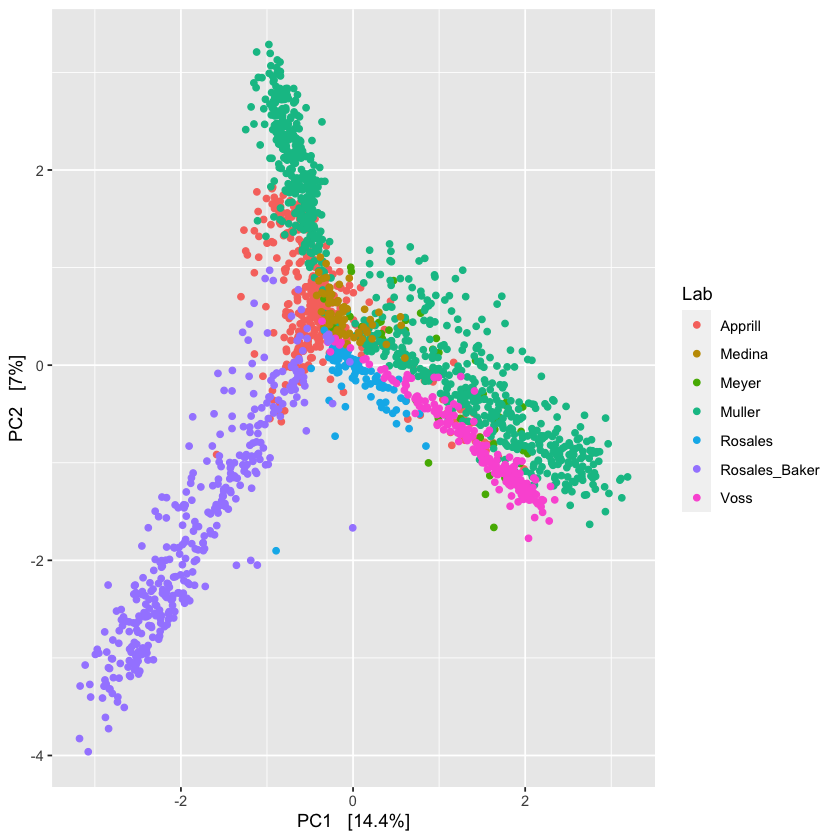

In [10]:
ord_lab = plot_ordination(ps_clr, psr_clr.ord,
                                 color="Lab",
                              shape="pimers_names", axes = c(1,2)) 
ord_lab

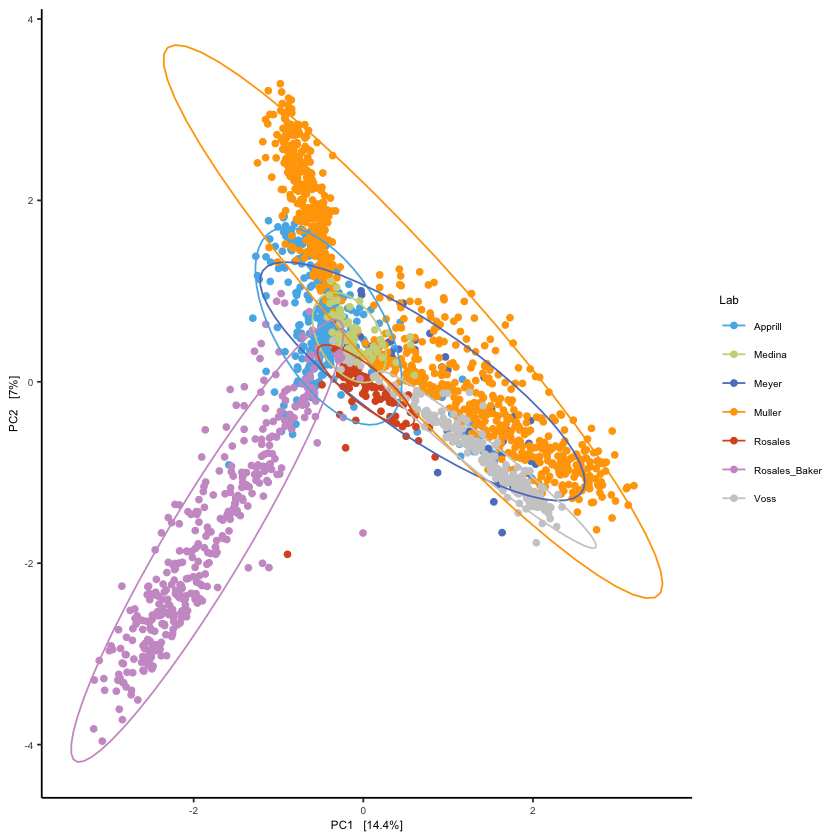

In [11]:
ord_lab +
scale_color_manual(values=c("#56B4E9","#CBD588","#5F7FC7", "orange","#DA5724","#CD9BCD",
                           "gray80", "#AD6F3B", "#673770","#D14285", "#652926","#8569D5", 
                           "#5E738F","#D1A33D", "#8A7C64","lightsalmon","aquamarine4",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                           "#CD9BCD", "gray80",
                           "#AD6F3B", "#673770","#D14285", "#652926","#8569D5", "#5E738F",
                          "#56B4E9","#CBD588","#5F7FC7", "orange","#DA5724","#CD9BCD")) +
theme_classic() +
theme(legend.text =element_text(size=6),
     legend.title=element_text(size=7)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +

stat_ellipse()

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/lab_type.png",
        width = 5, height = 5, units = "in", dpi=250)

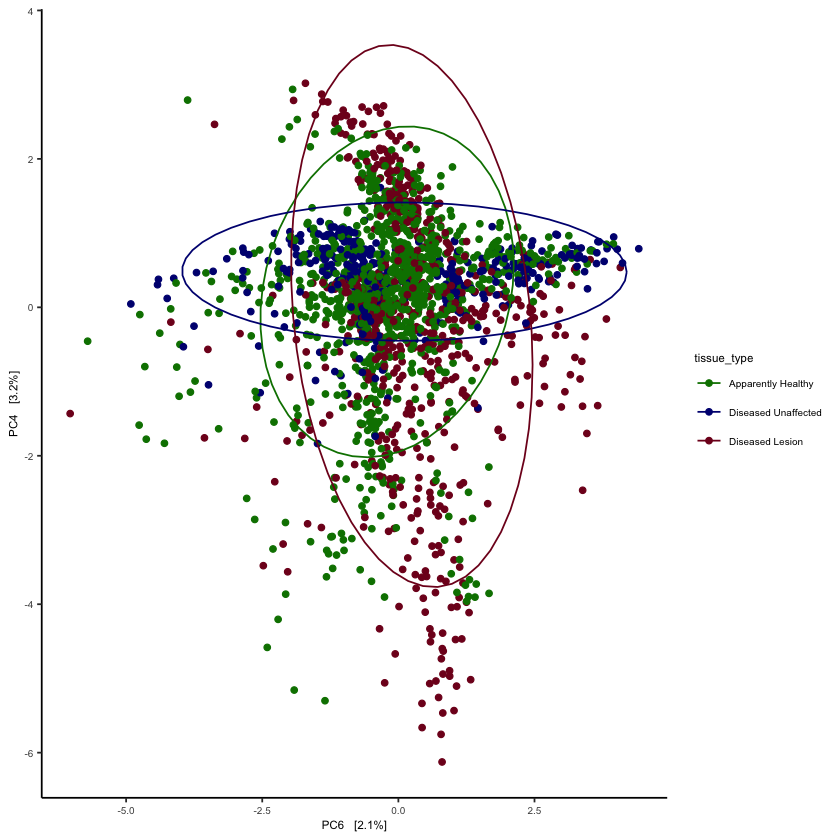

In [12]:
sample_data(ps_clr)$tissue_type = factor(sample_data(ps_clr)$tissue_type,
                                  c("AH", "DU", "DL")) 

plot_ordination(ps_clr, psr_clr.ord,
                               color="tissue_type",
                               axes = c(6,4)) +
theme_classic() +
theme(legend.text =element_text(size=6),
     legend.title=element_text(size=7)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =6)) +
scale_color_manual(values=c("#007f00", "Navy", "#800020"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion")) +
stat_ellipse()

#ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/Ord_health.png",
 #       width = 5, height = 5, units = "in", dpi=250)

# Dispersion analysis 

In [13]:

dis_clr <- vegdist(otu_table(t(ps_coral)), method ="euclidean")
# PERMDISP2 procedure for the analysis of multivariate homogeneity of group dispersions (variances).
mod_clr <- betadisper(dis_clr, sample_data(ps_coral)$tissue_type)
mod_clr
mod_dist_clr= as.data.frame(mod_clr$distances)
dim(mod_dist_clr)
mod_dist_df_clr=cbind(sample_data(ps_coral), mod_dist_clr) 
head(mod_dist_df_clr)


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis_clr, group =
sample_data(ps_coral)$tissue_type)

No. of Positive Eigenvalues: 1481
No. of Negative Eigenvalues: 0

Average distance to median:
   AH    DL    DU 
27913 52471 24138 

Eigenvalues for PCoA axes:
(Showing 8 of 1481 eigenvalues)
    PCoA1     PCoA2     PCoA3     PCoA4     PCoA5     PCoA6     PCoA7     PCoA8 
1.808e+12 1.199e+12 9.778e+11 6.938e+11 3.606e+11 2.425e+11 1.655e+11 1.347e+11 

[1] 1978    1

,BioSample,Run,SRA_accession,Lab,Experiment,Alias,Collection_ID,collection_time,collection_year,collection_month,⋯,forwardPrimer,ReversePrimer,linkerPrimerSequence,platform,platformChemistry,sequencing_facility,barcodes,basepairs,notes,mod_clr$distances
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>
102tiss_S3,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,102tiss,3:08:00PM,2020,February,⋯,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA,75898.01
220tiss_S33,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,220tiss,10:11:00AM,2020,February,⋯,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA,24943.16
222tiss_S34,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,222tiss,10:11:00AM,2020,February,⋯,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA,56041.42
225tis_S40,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,225tis,10:11:00AM,2020,February,⋯,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA,42067.15
232tiss_S41,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,232tiss,10:11:00AM,2020,February,⋯,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA,20063.80
262tiss_S35,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,262tiss,12:23:00PM,2020,February,⋯,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA,32112.52


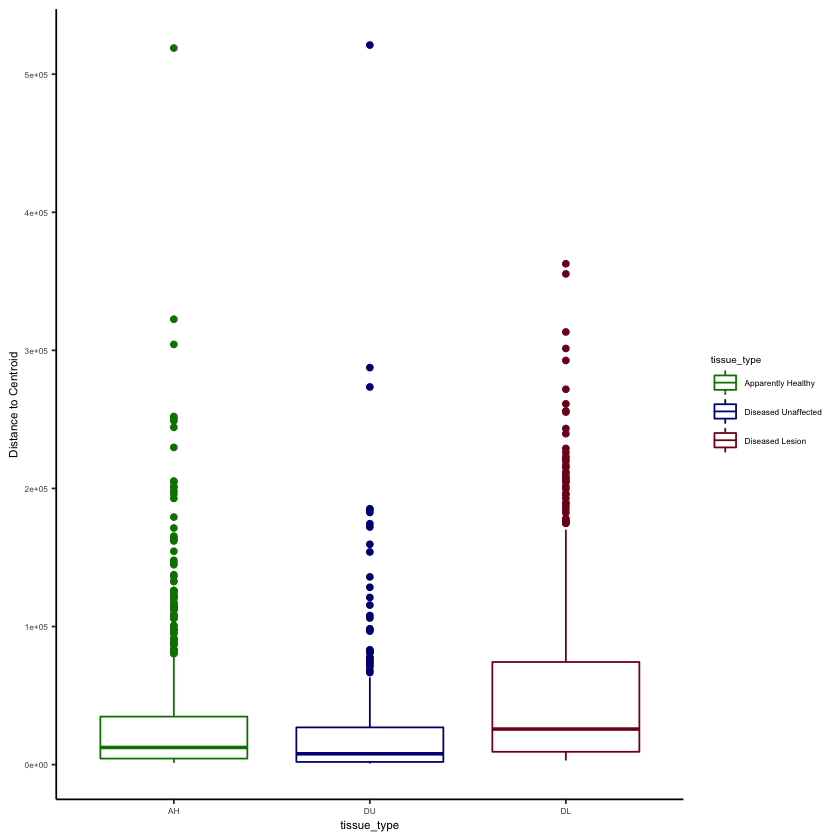

In [14]:
#plot variance 
#cbPalette <- c( "#009E73","#696969", "#D55E00")
mod_dist_df_clr$tissue_type = factor(mod_dist_df_clr$tissue_type,
                                  c("AH", "DU", "DL")) 


ggplot(mod_dist_df_clr,
       aes(x=tissue_type, y=mod_clr$distances)) +
geom_boxplot(aes(color=tissue_type)) +
#scale_color_manual(values = cbPalette) +
theme_linedraw() +
theme_classic() +
ylab("Distance to Centroid") +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 7)) +
theme(axis.title.y = element_text(size = 7)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +

scale_color_manual(values=c("#007f00", "Navy", "#800020"),
                  labels=c(AH="Apparently Healthy",
                            DU="Diseased Unaffected", 
                            DL="Diseased Lesion"))

In [15]:

#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
permutest(mod_clr, pairwise = TRUE, permutations = 999)
TukeyHSD(mod_clr)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
            Df     Sum Sq    Mean Sq      F N.Perm Pr(>F)    
Groups       2 2.8656e+11 1.4328e+11 56.801    999  0.001 ***
Residuals 1975 4.9818e+12 2.5224e+09                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
           AH         DL    DU
AH            1.0000e-03 0.156
DL 4.9192e-21            0.001
DU 1.6730e-01 2.8148e-13      

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
            diff       lwr        upr    p adj
DL-AH  24558.465  18598.44  30518.491 0.000000
DU-AH  -3774.889 -11168.69   3618.907 0.454794
DU-DL -28333.354 -36222.67 -20444.038 0.000000


# Group differences 

In [16]:
ps_clr_df=as.data.frame(otu_table(ps_clr_sctld))
ps_clr_meta= as(sample_data(ps_clr_sctld), "data.frame")

In [27]:
ps_clr_meta_edit = ps_clr_meta %>% 
#as.tibble() %>% 
dplyr::rename(Study = Alias) %>%
#dplyr::rename("Biome" = environment_.biome.) %>% 
dplyr::rename("Dissease.Status" = tissue_type) %>%
dplyr::rename("Diseased.Colony" = binary_disease) %>%
dplyr::rename("Coral.Species" = species_code) %>%
dplyr::rename("Coral.Compartment" = sample_type) %>%
dplyr::rename(Primers = primer_names)
head(ps_clr_meta_edit)

,BioSample,Run,SRA_accession,Lab,Experiment,Study,Collection_ID,collection_time,collection_year,collection_month,⋯,Primers,forwardPrimer,ReversePrimer,linkerPrimerSequence,platform,platformChemistry,sequencing_facility,barcodes,basepairs,notes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
102tiss_S3,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,102tiss,3:08:00PM,2020,February,⋯,515FPr_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA
220tiss_S33,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,220tiss,10:11:00AM,2020,February,⋯,515FPr_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA
222tiss_S34,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,222tiss,10:11:00AM,2020,February,⋯,515FPr_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA
225tis_S40,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,225tis,10:11:00AM,2020,February,⋯,515FPr_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA
232tiss_S41,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,232tiss,10:11:00AM,2020,February,⋯,515FPr_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA
262tiss_S35,TBD,Run1_BPC29622-1521,TBD,Apprill,FieldSampling_SCTLD_USVI_Feb2020,USVIFeb2020,262tiss,12:23:00PM,2020,February,⋯,515FPr_806RAp,GTGYCAGCMGCCGCGGTAA,GGACTACNVGGGTWTCTAAT,TBD,Illumina,iSeq100i1,"HomeRentalonSt.Thomas,USVI",NA,150,NA


In [28]:
colnames(ps_clr_meta_edit)

[1] "BioSample"                       "Run"                            
 [3] "SRA_accession"                   "Lab"                            
 [5] "Experiment"                      "Study"                          
 [7] "Collection_ID"                   "collection_time"                
 [9] "collection_year"                 "collection_month"               
[11] "collection_date"                 "collected_by"                   
[13] "environment_.biome."             "Biome"                          
[15] "latitude"                        "longitude"                      
[17] "country"                         "reef_name"                      
[19] "reef_abbr"                       "reef_type"                      
[21] "SCTLD_status"                    "SCTLD_site_duration"            
[23] "depth"                           "temperature"                    
[25] "salinity"                        "pH"                             
[27] "nutrientdatacollected."          "Coral.Compartment"              
[29] "binary_algal_contact"            "Diseased.Colony"                
[31] "binary_bleaching"                "Dissease.Status"                
[33] "field_host_family_id"            "field_host_genus_id"            
[35] "field_host_species_id"           "Coral.Species"                  
[37] "project_colony_code"             "colony_max_diameter"            
[39] "colony_max_height"               "colony_old_mortality"           
[41] "colony_recent_mortality_disease" "colony_percent_diseased"        
[43] "lesion_distribution"             "lesion_start"                   
[45] "lesion_rate"                     "lesion_margin"                  
[47] "disease_colony_sample_distance"  "complex_robust"                 
[49] "dna_extraction_method"           "X16S_variable_region"           
[51] "Primers"                         "forwardPrimer"                  
[53] "ReversePrimer"                   "linkerPrimerSequence"           
[55] "platform"                        "platformChemistry"              
[57] "sequencing_facility"             "barcodes"                       
[59] "basepairs"                       "notes"

In [20]:
 p <- pca(ps_clr_df, metadata = ps_clr_meta_edit, removeVar = 0.1)

-- removing the lower 10% of variables based on variance



Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Study is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Primers is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Biome is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Coral.Species is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Dissease.Status is not numeric - please check the source data as non-numeric variable

Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = cor

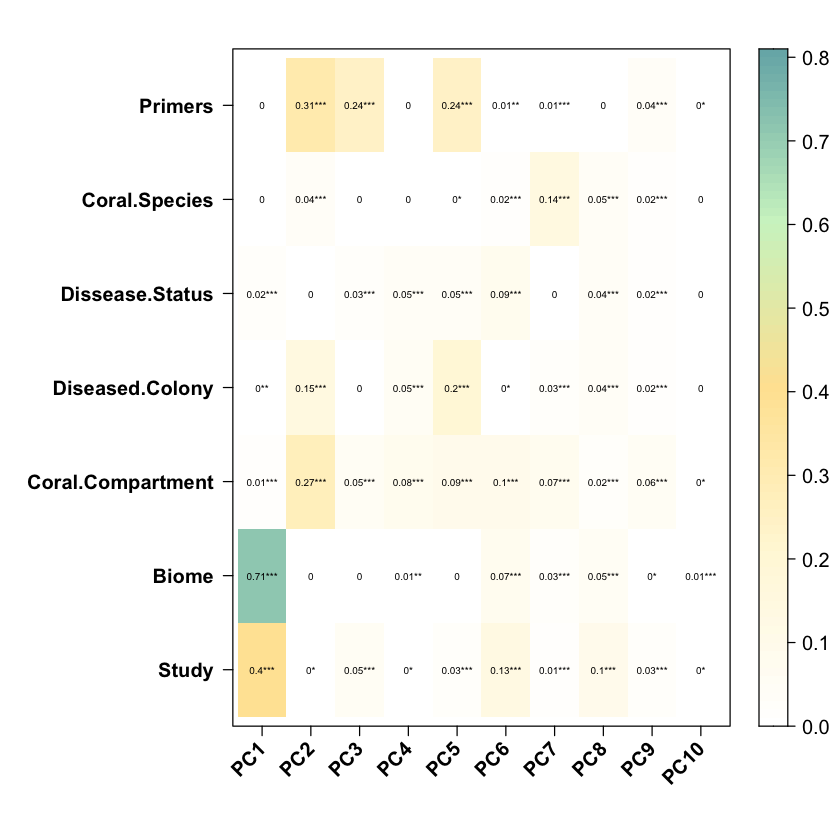

In [21]:

 eigencorplot(p,
    metavars = c("Study", "Primers", "Biome", "Coral.Species", 
                 "Dissease.Status", "Diseased.Colony", "Coral.Compartment"),
              col = c('white', 'cornsilk1', "#FFE4A1",  '#CFF3CA', "#77B3B5"),
    cexCorval = 0.5,
    fontCorval = 0.5,
    cexTitleX = 4,
    
    #posLab = 'all',
    rotLabX = 45,
    scale = TRUE,
    plotRsquared = TRUE,
    corFUN = 'spearman',
    corUSE = 'pairwise.complete.obs',
    corMultipleTestCorrection = 'BH')
    #signifSymbols = c( '***', '**', '*', ''),
    #signifCutpoints = c( 0, 0.01, 0.05, 1))

In [22]:
jpeg("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/PC_R2.jpeg", width = 5.5, height = 5,
     units = 'in', res = 250)

 eigencorplot(p,
    metavars = c("Study", "Primers", "Biome", "Coral.Species", 
                 "Dissease.Status", "Diseased.Colony", "Coral.Compartment", "collection_year"),
              col = c('white', 'cornsilk1', "#FFE4A1",  '#CFF3CA', "#77B3B5"),
    cexCorval = 0.5,
    fontCorval = 0.5,
    cexTitleX = 4,
    
    #posLab = 'all',
    rotLabX = 45,
    scale = TRUE,
    plotRsquared = TRUE,
    corFUN = 'spearman',
    corUSE = 'pairwise.complete.obs',
    corMultipleTestCorrection = 'BH')
    #signifSymbols = c( '***', '**', '*', ''),
    #signifCutpoints = c( 0, 0.01, 0.05, 1))

dev.off()


Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Study is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Primers is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Biome is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Coral.Species is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Dissease.Status is not numeric - please check the source data as non-numeric variable

Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = cor

pdf 
  2

Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Study is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Primers is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Biome is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Coral.Species is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Study", "Primers", "Biome", "Coral.Species", :
“Dissease.Status is not numeric - please check the source data as non-numeric variable

Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = cor

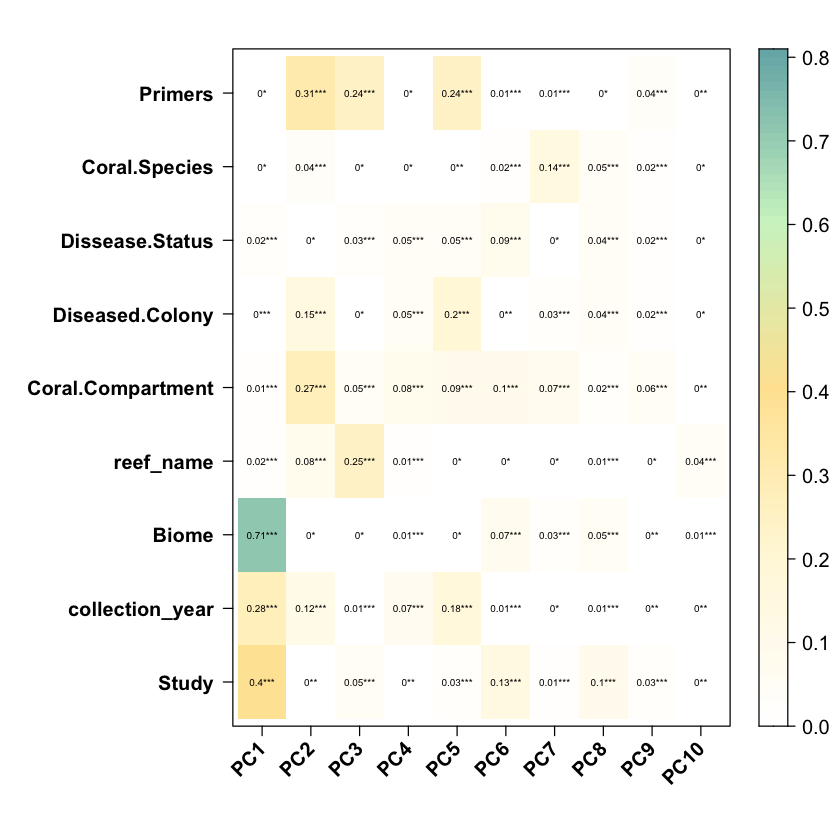

In [29]:
eigencorplot(p,
    metavars = c("Study", "Primers", "Biome", "Coral.Species", 
                 "Dissease.Status", "Diseased.Colony", "Coral.Compartment", "collection_year", "reef_name"),
              col = c('white', 'cornsilk1', "#FFE4A1",  '#CFF3CA', "#77B3B5"),
    cexCorval = 0.5,
    fontCorval = 0.5,
    cexTitleX = 4,
    
    #posLab = 'all',
    rotLabX = 45,
    scale = TRUE,
    plotRsquared = TRUE,
    corFUN = 'spearman',
    corUSE = 'pairwise.complete.obs',
    corMultipleTestCorrection = 'BH',
    signifSymbols = c( '***', '**', '*'),
    signifCutpoints = c(0, 0.01, 0.05, 1))

In [ ]:
sc <- vegan::scores(psr_clr.ord)$sites


In [ ]:
pairwise.adonis(ps_clr_df, ps_clr_meta$tissue_type, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

In [ ]:
pairwise.adonis(ps_clr_df, ps_clr_meta$Alias, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

# Taxonomy summary

In [ ]:
sum_ps   <- ps_coral  %>%
  tax_glom(taxrank = "Family") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()


In [ ]:
sum_ps$tissue_type <- factor(sum_ps$tissue_type, 
    levels = c("AH","DU", "DL"))
ggplot(subset(sum_ps, Abundance >0.5 ), 
       aes(x =sample_type, y=Abundance, fill=Order)) + 
geom_bar(stat="identity", position="fill") +
facet_grid(tissue_type~., scales = "free") +
scale_fill_manual(values=c("#56B4E9","#CBD588","#5F7FC7", "orange","#DA5724","#CD9BCD",
                           "gray80", "#AD6F3B", "#673770","#D14285", "#652926","#8569D5", 
                           "#5E738F","#D1A33D", "#8A7C64","lightsalmon","aquamarine4",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                           "#CD9BCD", "gray80",
                           "#AD6F3B", "#673770","#D14285", "#652926","#8569D5", "#5E738F",
                          "#56B4E9","#CBD588","#5F7FC7", "orange","#DA5724","#CD9BCD", "blue", "red")) +
guides(fill = guide_legend(keywidth = 0.5, , keyheight =.70, ncol=1)) +
theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
theme_classic()

In [ ]:
R.version